<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Evaluating Model Params using Slurm configs

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import time
import copy
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import SimpleITK as sitk
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import pickle as pkl
from tensorboardX import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
from torchsummary import summary
import torch
import torch.nn as nn
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from lmfit.models import LinearModel

%aimport mre 
from mre import pytorch_arch
%aimport mre.mre_datasets
from mre.mre_datasets import MRETorchDataset, MREtoXr
%aimport mre.plotting
from mre.plotting import hv_dl_vis, hv_pred_comp, xr_viewer_v2, miccai_plots
%aimport mre.train_mre_model
from mre.train_mre_model import train_model_full
%aimport mre.prediction
from mre.prediction import add_predictions, get_linear_fit, add_val_linear_cor

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import hvplot.pandas


ImportError: cannot import name 'encode_utf8'

In [2]:
if 'ds_test' in locals():
    ds_test.close()
if 'ds_val' in locals():
    ds_val.close()
#from_file = '/pghbio/dbmi/batmanlab/Data/MRE/XR_with_contrast_full_gold/*.nc'
#from_file = '/pghbio/dbmi/batmanlab/Data/MRE/XR_full_gold_v3/*.nc'
from_file = '/pghbio/dbmi/batmanlab/Data/MRE/XR_full_gold_clinical_v3/*.nc'

# run_id = '2019-12-03_12-13-25_n0'
# run_id = '2019-12-04_12-05-34_n0'
# run_id = '2019-12-12_16-32-10_n0'
#run_id = '2019-12-26_14-19-32_n0'
# run_id = '2020-01-07_13-15-44'
#run_id = '2020-01-08_13-12-35'
#run_id = '2020-01-18_11-05-59'
#run_id = '2020-01-26_17-29-32'
#run_id = '2020-02-15_21-44-51'
#run_id = '2020-02-16_16-27-02'
#run_id = '2020-02-21_14-06-27'
#run_id = '2020-03-02_14-22-01'
# run_id = '2020-03-02_23-01-45'
# run_id = '2020-03-03_21-46-14'
# run_id = '2020-03-08_22-48-00'
# run_id = '2020-03-09_10-09-32'
# run_id = '2020-03-10_12-53-02'
# run_id = '2020-03-10_12-59-58'
# run_id = '2020-03-10_18-07-54'
# run_id = '2020-03-11_22-33-30'
# run_id = '2020-03-13_15-33-06'

# run_id = '2020-03-12_11-41-01' # direct subj pred
# run_id = '2020-03-14_12-28-54' #l2 no smear
# run_id = '2020-03-10_20-29-37' #blocks 54
# run_id = '2020-03-11_22-33-30' #blocks 76
# run_id = '2020-03-14_17-31-51' # many block sweeps
# run_id = '2020-03-15_14-07-15' #blocks 32
# run_id = '2020-03-15_17-47-31' # Uniform

# run_id = '2020-03-19_12-50-21' # smart sampling
# run_id = '2020-03-20_13-26-00' #smart with 5% val check
# run_id = '2020-03-20_18-09-16' #smart with 1% val check
# run_id = '2020-03-23_14-09-14' # smearing tests, 1,2,3,4,5,6 median
# run_id = '2020-03-24_23-10-35' # no smearing, rand_epoch
# run_id = '2020-03-25_15-37-42' # rand smearing, rand_epoch
# run_id = '2020-03-26_14-53-38' # no smearing, rand_epoch, testing inputs (small sets)
# run_id = '2020-03-26_21-57-02' # no smearing, rand_epoch, 3 inputs (t1_pre_water, t1_pre_fat, t1_pos_70_water)
# run_id = '2020-03-27_10-59-38' # no smearing, rand_epoch, 3 inputs (t1_pre_water, t1_pre_fat, t2)

# run_id = '2020-04-10_10-31-02' # all inputs, no smearing, clinical first test, no clinical features
# run_id = '2020-04-10_20-59-57' # all inputs, no smearing, clinical first test, clinical features
# run_id = '2020-04-11_16-59-40' # all inputs, no smearing, clinical first test, clinical features
# run_id = '2020-04-13_09-45-21' # all inputs, no smearing, no clinical feautres, pixel 0.5
# run_id = '2020-04-14_14-30-32' # 3 inputs, no smearing, no clinical feautres, mask erode 3
# run_id = '2020-04-15_10-55-56' # 3 inputs, no smearing, clinical feautres, mask erode 3
# run_id = '2020-04-15_14-59-29' # 3 inputs, no smearing, clinical feautres, mask erode 3, pixel 0.5
# run_id = '2020-04-24_10-35-46' # 3 inputs, no smearing, clinical feautres, mask erode 3, rand_seed tests
# run_id = '2020-04-28_17-53-22'
# run_id = '2020-05-01_15-46-22'


# New set of random seed trials
# run_id = '2020-05-06_13-00-03'
#run_id = '2020-05-08_14-54-44' # single test strat
#run_id = '2020-05-10_19-20-15' # single test strat
#run_id = '2020-05-11_09-20-19' # single test strat
# run_id = '2020-05-12_14-00-22' # single test strat
#run_id = '2020-05-13_16-24-04' # single test strat
#run_id = '2020-05-15_11-48-18' # single test strat
#run_id = '2020-05-16_12-15-21' # single test strat
#run_id = '2020-05-16_17-13-05' # single test strat
#run_id = '2020-05-17_10-32-19' # single test strat
#run_id = '2020-05-18_09-27-22' # single test strat
#run_id = '2020-05-18_17-41-57' # single test strat
#run_id = '2020-05-19_16-43-07' # single test strat
# run_id = '2020-05-20_10-57-06' # single test strat
# run_id = '2020-06-02_15-28-26' # single test strat
#run_id = '2020-06-04_13-23-25' # single test strat
#run_id = '2020-06-09_13-47-50' # LOO
#run_id = '2020-06-11_14-19-00' # LOO
#run_id = '2020-06-12_14-04-48' # LOO
#run_id = '2020-06-13_12-54-40'
#run_id = '2020-06-14_18-10-49'
#run_id = '2020-06-15_14-43-31'
#run_id = '2020-06-17_13-36-20'
#run_id = '2020-06-17_18-10-21'
#run_id = '2020-06-18_16-03-04'
#run_id = '2020-06-22_10-18-16'
# run_id = '2020-06-22_17-45-55' # new baseline?
# run_id = '2020-06-23_21-35-15' # image sequence single tests
run_id = '2020-06-26_13-28-52' # new three
# run_id = '2020-06-26_13-55-29' # new 5
# run_id = '2020-06-26_14-02-50' # new 9
run_version = 'n0'
#group = 'GROUP3'
group = ''

slurm_config_dir = '../data/config/'
config_path = Path(slurm_config_dir)
df_config = pd.DataFrame()
for f in list(config_path.glob(run_id+'*.pkl')):
    s_tmp = pd.Series(pd.read_pickle(str(f)), name=f.stem)
    df_config = df_config.append(s_tmp, ignore_index=False)

# xr_maker_train = MREtoXr(from_file=from_file,
#     from_file_pred=f'/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/XR/{run_id}_{run_version}/train/*.nc')
# ds_train = xr_maker_train.get_ds()
# ds_train = ds_train.load()
#xr_maker_val = MREtoXr(from_file=from_file,
#    from_file_pred=f'/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/XR/{run_id}_{run_version}/val/*{group}.nc')
#ds_val = xr_maker_val.get_ds()
#ds_val = ds_val.load()
xr_maker_test = MREtoXr(from_file=from_file,
    from_file_pred=f'/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/XR/{run_id}_{run_version}/test/*{group}.nc')
ds_test = xr_maker_test.get_ds()
ds_test = ds_test.load()


Called by IPython.
Within IPython QtConsole.
pylab loaded, but not in inline mode.
['1045' '1329' '1714' '1935' '0509' '1336' '1367' '1839' '1736' '1843'
 '1853' '1980' '0659' '1400' '1447' '1642' '0126' '0737' '1829' '1899'
 '0860' '1395' '1706' '1785' '0655' '0704' '1790' '2029' '1448' '1474'
 '1574' '1903' '0135' '0747' '1541' '1948' '0914' '1530' '1578' '1722'
 '0735' '0979' '1550' '2034' '0628' '1149' '1456' '1765' '0931' '0937'
 '1699' '1819' '0556' '0929' '1072' '1119' '0830' '0932' '1271' '1694'
 '1667' '1720' '1806' '1979' '0344' '0401' '1311' '1491' '0415' '0940'
 '1360' '1417' '0291' '0491' '0612' '1217' '0006' '0510' '1144' '1464'
 '0020' '1337' '1561' '1896' '1083' '1453' '2001' '2046' '0173' '0461'
 '1287' '0234' '1077' '1341' '1748' '0954' '1798' '2007' '0653' '1595'
 '1671' '0564' '1103' '1504' '0029' '1529' '1789' '0975' '1110' '1577'
 '1526' '1603' '1786' '1793' '1795' '1940' '0492' '0890' '1679' '0904'
 '1106' '1590' '1554' '1727' '1893' '0210' '0898' '1382' '1967' '

In [3]:
ds_test

<xarray.Dataset>
Dimensions:         (mask_type: 3, mre_type: 5, sequence: 9, subject: 149, x: 256, y: 256, z: 32, z_idx: 4)
Coordinates:
  * y               (y) int64 255 254 253 252 251 250 249 248 ... 6 5 4 3 2 1 0
  * mask_type       (mask_type) object 'liver' 'mre' 'combo'
  * z               (z) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * sequence        (sequence) object 't1_pre_water' ... 't1_pos_300_water'
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
  * z_idx           (z_idx) int64 0 1 2 3
  * mre_type        (mre_type) object 'mre' 'mre_mask' ... 'mre_wave' 'mre_pred'
  * subject         (subject) object '1045' '1329' '1714' ... '1121' '1715'
Data variables:
    image_mri       (subject, sequence, x, y, z) int16 0 0 0 0 0 0 ... 0 0 0 0 0
    mask_mri        (subject, mask_type, x, y, z) int16 0 0 0 0 0 ... 0 0 0 0 0
    image_mre       (subject, mre_type, x, y, z) int16 0 0 0 ... -290 -240 -190
    mask_mre        (subject, mask_type, x, y, z) int16 0 0 0 0 0 ... 0 0 0 0 0
    mri_to_mre_idx  (subject, z_idx) int16 17 19 21 23 17 19 ... 23 14 16 18 20
    age             (subject) float64 65.0 34.0 71.0 61.0 ... 60.0 36.0 68.0
    gender          (subject) float64 0.0 0.0 1.0 1.0 0.0 ... 1.0 1.0 0.0 0.0
    height          (subject) float64 173.0 194.0 145.0 ... 167.0 178.0 172.0
    weight          (subject) float64 69.0 128.0 69.4 90.7 ... 91.0 96.0 99.5
    bmi             (subject) float64 23.2 34.0 33.01 32.14 ... 33.4 30.42 33.63
    htn             (subject) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    hld             (subject) float64 1.0 1.0 1.0 1.0 0.0 ... 0.0 1.0 0.0 0.0
    dm              (subject) float64 0.0 0.0 0.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    ast             (subject) float64 37.0 22.0 43.0 85.0 ... 38.0 60.0 28.0
    alt             (subject) float64 33.0 34.0 24.0 74.0 ... 28.0 100.0 29.0
    alk             (subject) float64 103.0 82.0 122.0 157.0 ... 79.0 95.0 136.0
    tbili           (subject) float64 0.9 0.4 0.7 0.6 0.7 ... 0.8 0.9 1.4 1.3
    albumin         (subject) float64 3.3 4.7 3.7 4.3 3.5 ... 3.6 3.8 4.5 4.1
    plt             (subject) float64 197.0 211.0 158.0 ... 96.0 329.0 60.0
    val_slope       (subject) float64 0.4958 0.4958 0.4958 ... 0.6754 0.6754
    val_intercept   (subject) float64 1.79e+03 1.79e+03 ... 1.133e+03 1.133e+03

In [4]:
df = miccai_plots(ds_test, do_cor=False, erode=2)
# tp = df.query('true>4 and predict>4').count()[0]
# fn = df.query('true>4 and predict<4').count()[0]
# print('tp', tp)
# print('fn', fn)
# print('sensitivity', tp/(tp+fn))
# 
# # Specificity: TN/(TN+FP)
# tn = df.query('true<4 and predict<4').count()[0]
# fp = df.query('true<4 and predict>4').count()[0]
# print('tn', tn)
# print('fp', fp)
# print('specificity', tn/(tn+fp))
# scatter = hv.Scatter(df, ['true', 'predict'])
# scatter = scatter.opts(width=500, height=500, size=5, legend_position='top', tools=['hover'])
# scatter = scatter.redim.range(true=(1000,10000), predict=(1000,10000))
# scatter = scatter.redim.label(true='True Average Stiffness (Pa)', predict='Predicted Average Stiffness (Pa)')
# boxes = hv.Polygons([hv.Box(2500,2500,3000), hv.Box(7000,7000,6000)], label='Correct Class').opts(alpha=0.1, color='k', show_legend=True)
# scatter.opts(color='fibrosis', cmap='Colorblind')*boxes

NameError: name 'miccai_plots' is not defined

In [23]:
ds_test = ds_test.sortby('subject')

In [12]:
%%capture --no-display
xr_viewer_v2(ds_test, size=250, prediction=True)

Column
    [0] WidgetBox(css_classes=['widget-box'])
        [0] DiscreteSlider(formatter='%d', margin=(20, 20, 5, 20), name='z', options=OrderedDict([('0', ...]), value=0, width=250)
        [1] Select(margin=(0, 20, 5, 20), name='subject', options=['0006', '0020', ...], value='0006', width=250)
        [2] Select(margin=(5, 20, 20, 20), name='mask_type', options=['liver', 'mre', 'combo'], value='liver', width=250)
        [3] FloatSlider(end=1, name='mask transparency', start=0, value=0.7)
        [4] RangeSlider(end=2000, name='contrast', step=1, value=(0, 1000))
        [5] RangeSlider(end=12000, name='mre contrast', step=1, value=(0, 10000))
    [1] HoloViews(Layout)

0.6570207533339826 3212.1678530379563
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 167
    # variables        = 2
    chi-square         = 9.2910e+08
    reduced chi-square = 5630905.41
    Akaike info crit   = 2597.79932
    Bayesian info crit = 2604.03531
[[Variables]]
    slope:      0.99572645 +/- 0.11220347 (11.27%) (init = 0.5)
    intercept:  222.593592 +/- 490.486796 (220.35%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.927
R2: 0.32308545846424785


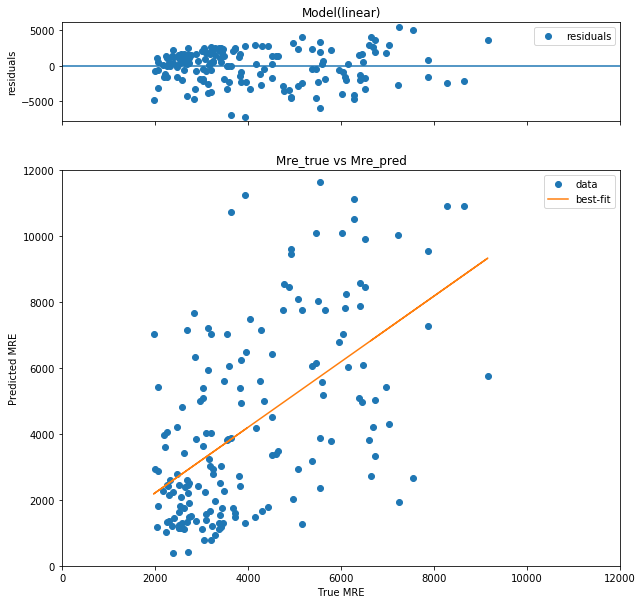

In [23]:
df = get_linear_fit(ds_test, do_cor=True, return_df=True)

In [11]:
df.sort_values('true', inplace=True)

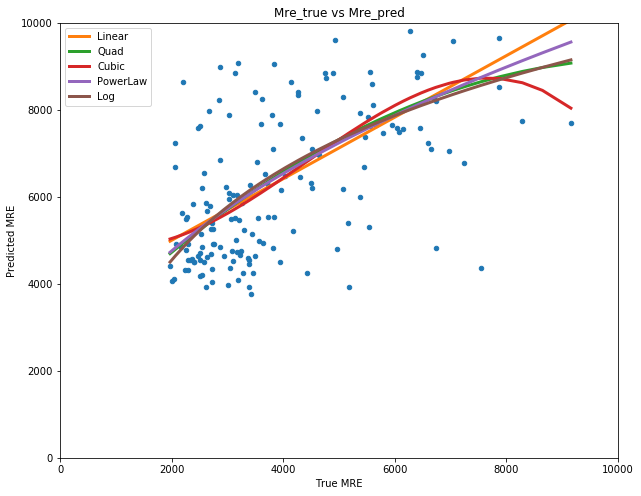

In [12]:
from lmfit.models import LinearModel, PowerLawModel, ExponentialModel, PolynomialModel, ExpressionModel

names = ['Linear', 'Quad', 'Cubic', 'PowerLaw', 'Log']
mods = [LinearModel(), PolynomialModel(2), PolynomialModel(3), PowerLawModel(), ExpressionModel('off + amp * log(x)')]
results = []
for i, model in enumerate(names):
    if names[i] != 'Log':
        params = mods[i].guess(df['predict'], x=df['true'])
    else:
        params = mods[i].make_params(off=0, amp=10)
        
    results.append(mods[i].fit(df['predict'], params, x=df['true']))
    # print(results[i].fit_report())

#result.plot()
df.plot(x='true', y='predict', kind='scatter', xlim=(0, 10000), ylim=(0, 10000), color='C0')
# dely = result.eval_uncertainty(sigma=3)
# plt.fill_between(df['true'], result.best_fit-dely, result.best_fit+dely, color="#ABABAB",
#                  label='3-$\sigma$ uncertainty band', alpha=0.5)
for i, res in enumerate(results):
    plt.plot(df['true'], res.best_fit, label=names[i], linewidth=3, c=f'C{i+1}')
    #print(result.fit_report())
    #print('R2:', 1 - result.residual.var() / np.var(df['predict']))


plt.title('Mre_true vs Mre_pred')
plt.ylim(0, 10000)
plt.xlim(0, 10000)
plt.xlabel('True MRE')
plt.ylabel('Predicted MRE')
plt.legend()
f = plt.gcf()
f.set_facecolor('w')
#plt.show()



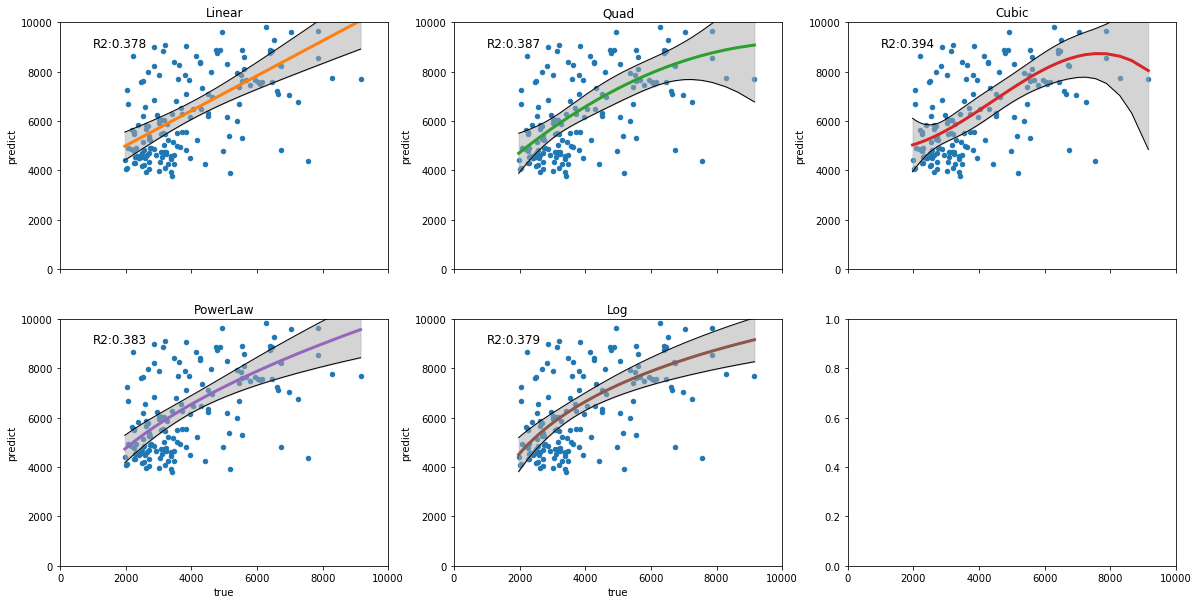

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20,10), sharex=True) 
fig.set_facecolor('w')
axes = np.ravel(axes)
for i,res in enumerate(results):
    df.plot(x='true', y='predict', kind='scatter', xlim=(0, 10000), ylim=(0, 10000), color='C0', ax=axes[i], title=names[i])
    axes[i].plot(df['true'], res.best_fit, label=names[i], linewidth=3, c=f'C{i+1}')
    dely = res.eval_uncertainty(sigma=3)
    axes[i].plot(df['true'], res.best_fit+dely, label=names[i], linewidth=1, c='k')
    axes[i].plot(df['true'], res.best_fit-dely, label=names[i], linewidth=1, c='k')
    axes[i].fill_between(df['true'], res.best_fit-dely, res.best_fit+dely, color="#ABABAB",
                     label='3-$\sigma$ uncertainty band', alpha=0.5)
    r2 = 1 - res.residual.var() / np.var(df['predict'])
    axes[i].text(0.1, 0.9, f'R2:{r2:.3f}', fontsize=12, transform=axes[i].transAxes)

In [13]:
scatter = hv.Scatter(df, ['true', 'predict'])
scatter = scatter.opts(width=500, height=500, size=5, legend_position='top', tools=['hover'])
scatter = scatter.redim.range(true=(1,10), predict=(1,10))
scatter = scatter.redim.label(true='True Average Stiffness (Pa)', predict='Predicted Average Stiffness (Pa)')
boxes = hv.Polygons([hv.Box(2.500,2.500,3.000), hv.Box(7.000,7.000,6.000)], label='Correct Class').opts(alpha=0.1, color='k', show_legend=True)
scatter.opts(color='fibrosis', cmap='Colorblind')*boxes
#ideal_curve = hv.Curve([(1000,1000), (9000,9000)], label='Ideal Prediction').opts(color='k', line_dash='dashed')
#fit_curve = hv.Curve(list(zip(x, out.best_fit.values)), label='Best Fit')

:Overlay
   .Scatter.I              :Scatter   [true,predict]   (subject,fibrosis)
   .Polygons.Correct_Class :Polygons   [x,y]

In [6]:
df

true    predict subject         fibrosis
0    3.727601   3.395062    0029    Mild Fibrosis
1    7.542570   3.000547    0291  Severe Fibrosis
2    5.598603   6.060562    0491  Severe Fibrosis
3    3.161660   2.990554    0556    Mild Fibrosis
4    3.805271   4.677226    0653    Mild Fibrosis
..        ...        ...     ...              ...
144  2.847283   5.655393    1819    Mild Fibrosis
145  4.259754   7.983723    1851  Severe Fibrosis
146  3.410156   3.971535    1883    Mild Fibrosis
147  6.966303  14.684440    1935  Severe Fibrosis
148  2.261857   3.091454    2029    Mild Fibrosis

[149 rows x 4 columns]

In [28]:
# Sensitivity: TP/(TP+FN)
tp = df.query('true>4000 and predict>4000').count()[0]
fn = df.query('true>4000 and predict<4000').count()[0]
print('tp', tp)
print('fn', fn)
print('sensitivity', tp/(tp+fn))

# Specificity: TN/(TN+FP)
tn = df.query('true<4000 and predict<4000').count()[0]
fp = df.query('true<4000 and predict>4000').count()[0]
print('tn', tn)
print('fp', fp)
print('specificity', tn/(tn+fp))

tp 47
fn 18
sensitivity 0.7230769230769231
tn 77
fp 25
specificity 0.7549019607843137


In [43]:
print(len(df))
print(len(df.query('true>3000 and predict<3000')))

167
44


In [44]:
18/176

0.10227272727272728

In [6]:
ds

<xarray.Dataset>
Dimensions:         (mask_type: 3, mre_type: 5, sequence: 9, subject: 176, x: 256, y: 256, z: 32, z_idx: 4)
Coordinates:
  * mask_type       (mask_type) object 'liver' 'mre' 'combo'
  * z_idx           (z_idx) int64 0 1 2 3
  * z               (z) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * mre_type        (mre_type) object 'mre' 'mre_mask' ... 'mre_wave' 'mre_pred'
  * sequence        (sequence) object 't1_pre_water' ... 't1_pos_300_water'
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 249 250 251 252 253 254 255
  * y               (y) int64 255 254 253 252 251 250 249 248 ... 6 5 4 3 2 1 0
  * subject         (subject) object '0006' '0020' '0024' ... '1083' '1103'
Data variables:
    image_mri       (subject, sequence, x, y, z) int16 0 0 0 0 0 0 ... 0 0 0 0 0
    mask_mri        (subject, mask_type, x, y, z) int16 0 0 0 0 0 ... 0 0 0 0 0
    image_mre       (subject, mre_type, x, y, z) int16 0 0 0 0 0 0 ... 0 0 0 0 0
    mask_mre        (subject, mask_type, x, y, z) int16 0 0 0 0 0 ... 0 0 0 0 0
    mri_to_mre_idx  (subject, z_idx) int16 18 20 22 24 18 21 ... 22 16 18 20 22
    val_slope       (subject) float64 0.2881 0.2881 0.2881 ... 0.4428 0.4428
    val_intercept   (subject) float64 2.614e+03 2.614e+03 ... 1.986e+03

In [8]:
ds.sel(mre_type='mre_pred')[['image_mre', 'val_slope', 'val_intercept']]

<xarray.Dataset>
Dimensions:        (subject: 176, x: 256, y: 256, z: 32)
Coordinates:
  * z              (z) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * subject        (subject) object '0006' '0020' '0024' ... '1083' '1103'
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 248 249 250 251 252 253 254 255
    mre_type       <U8 'mre_pred'
  * y              (y) int64 255 254 253 252 251 250 249 248 ... 7 6 5 4 3 2 1 0
Data variables:
    image_mre      (subject, x, y, z) int16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    val_slope      (subject) float64 0.2881 0.2881 0.2881 ... 0.4428 0.4428
    val_intercept  (subject) float64 2.614e+03 2.614e+03 ... 1.986e+03 1.986e+03

In [11]:
df = pd.DataFrame()
for f in list(config_path.glob(run_id+'*.pkl')):
    s_tmp = pd.Series(pd.read_pickle(str(f)), name=f.stem)
    df = df.append(s_tmp, ignore_index=False)
#baseline
# for f in list(config_path.glob('*2019-12-04_15-01-47_n0*.pkl')):
#     s_tmp = pd.Series(pd.read_pickle(str(f)))
#     df = df.append(s_tmp, ignore_index=True)
##coordconv off
#for f in list(config_path.glob('*2019-05-28_12-40-50*.pkl')):
#    s_tmp = pd.Series(pd.read_pickle(str(f)))
#    df = df.append(s_tmp, ignore_index=True)

# 331 runs
# for f in list(config_path.glob('*2019-05-29_16-08-51*.pkl')):
#     s_tmp = pd.Series(pd.read_pickle(str(f)), name=f.stem)
#     df = df.append(s_tmp, ignore_index=False)
# 331 runs 64
#for f in list(config_path.glob('*2019-05-29_21-11-13*.pkl')):
#    s_tmp = pd.Series(pd.read_pickle(str(f)), name=f.stem)
#    df = df.append(s_tmp, ignore_index=False)

In [12]:
df.shape

(90, 50)

In [13]:
pd.set_option('display.max_columns', 500)
df

batch_size   best_loss  channel_growth  \
2020-01-08_13-12-35_n14_GROUP0         8.0  255.370519             1.0   
2020-01-08_13-12-35_n7_GROUP2          8.0  279.852568             1.0   
2020-01-08_13-12-35_n15_GROUP3         8.0  261.430462             1.0   
2020-01-08_13-12-35_n6_GROUP1          8.0  309.514818             1.0   
2020-01-08_13-12-35_n15_GROUP4         8.0  283.774600             1.0   
...                                    ...         ...             ...   
2020-01-08_13-12-35_n16_GROUP2         8.0  279.661883             1.0   
2020-01-08_13-12-35_n5_GROUP0          8.0  247.111993             1.0   
2020-01-08_13-12-35_n17_GROUP1         8.0  275.565505             1.0   
2020-01-08_13-12-35_n4_GROUP3          8.0  290.834202             1.0   
2020-01-08_13-12-35_n4_GROUP4          8.0  306.379949             1.0   

                                coord_conv  depth  dims  do_val  dry_run  \
2020-01-08_13-12-35_n14_GROUP0         0.0    1.0   3.0     1.0      0.0   
2020-01-08_13-12-35_n7_GROUP2          0.0    0.0   3.0     NaN      0.0   
2020-01-08_13-12-35_n15_GROUP3         0.0    0.0   3.0     1.0      0.0   
2020-01-08_13-12-35_n6_GROUP1          0.0    1.0   3.0     NaN      0.0   
2020-01-08_13-12-35_n15_GROUP4         0.0    0.0   3.0     1.0      0.0   
...                                    ...    ...   ...     ...      ...   
2020-01-08_13-12-35_n16_GROUP2         0.0    1.0   3.0     1.0      0.0   
2020-01-08_13-12-35_n5_GROUP0          0.0    0.0   3.0     NaN      0.0   
2020-01-08_13-12-35_n17_GROUP1         0.0    0.0   3.0     1.0      0.0   
2020-01-08_13-12-35_n4_GROUP3          0.0    1.0   3.0     NaN      0.0   
2020-01-08_13-12-35_n4_GROUP4          0.0    1.0   3.0     NaN      0.0   

                                gamma  in_channels  \
2020-01-08_13-12-35_n14_GROUP0    0.3          9.0   
2020-01-08_13-12-35_n7_GROUP2     0.3          9.0   
2020-01-08_13-12-35_n15_GROUP3    0.3          9.0   
2020-01-08_13-12-35_n6_GROUP1     0.3          9.0   
2020-01-08_13-12-35_n15_GROUP4    0.3          9.0   
...                               ...          ...   
2020-01-08_13-12-35_n16_GROUP2    0.3          9.0   
2020-01-08_13-12-35_n5_GROUP0     0.3          9.0   
2020-01-08_13-12-35_n17_GROUP1    0.3          9.0   
2020-01-08_13-12-35_n4_GROUP3     0.3          9.0   
2020-01-08_13-12-35_n4_GROUP4     0.3          9.0   

                                                                           inputs  \
2020-01-08_13-12-35_n14_GROUP0  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n7_GROUP2   [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n15_GROUP3  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n6_GROUP1   [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n15_GROUP4  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
...                                                                           ...   
2020-01-08_13-12-35_n16_GROUP2  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n5_GROUP0   [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n17_GROUP1  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n4_GROUP3   [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n4_GROUP4   [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   

                               loss    lr  lr_max  lr_min lr_scheduler  \
2020-01-08_13-12-35_n14_GROUP0   l2  0.01    0.01  0.0001         step   
2020-01-08_13-12-35_n7_GROUP2    l2  0.01    0.01  0.0001         step   
2020-01-08_13-12-35_n15_GROUP3   l2  0.01    0.01  0.0001         step   
2020-01-08_13-12-35_n6_GROUP1    l2  0.01    0.01  0.0001         step   
2020-01-08_13-12-35_n15_GROUP4   l2  0.01    0.01  0.0001         step   
...                             ...   ...     ...     ...          ...   
2020-01-08_13-12-35_n16_GROUP2   l2  0.01 

In [64]:
df.query('model_cap==18 and train_smear=="median" and model_cap==18 and depth==1')

batch_size   best_loss  channel_growth  \
2020-01-08_13-12-35_n8_GROUP0         8.0  250.858236             1.0   
2020-01-08_13-12-35_n8_GROUP1         8.0  259.559301             1.0   
2020-01-08_13-12-35_n8_GROUP2         8.0  248.470770             1.0   
2020-01-08_13-12-35_n8_GROUP4         8.0  244.509843             1.0   
2020-01-08_13-12-35_n8_GROUP3         8.0  255.804521             1.0   

                               coord_conv  depth  dims  do_val  dry_run  \
2020-01-08_13-12-35_n8_GROUP0         0.0    1.0   3.0     NaN      0.0   
2020-01-08_13-12-35_n8_GROUP1         0.0    1.0   3.0     NaN      0.0   
2020-01-08_13-12-35_n8_GROUP2         0.0    1.0   3.0     1.0      0.0   
2020-01-08_13-12-35_n8_GROUP4         0.0    1.0   3.0     1.0      0.0   
2020-01-08_13-12-35_n8_GROUP3         0.0    1.0   3.0     1.0      0.0   

                               gamma  in_channels  \
2020-01-08_13-12-35_n8_GROUP0    0.3          9.0   
2020-01-08_13-12-35_n8_GROUP1    0.3          9.0   
2020-01-08_13-12-35_n8_GROUP2    0.3          9.0   
2020-01-08_13-12-35_n8_GROUP4    0.3          9.0   
2020-01-08_13-12-35_n8_GROUP3    0.3          9.0   

                                                                          inputs  \
2020-01-08_13-12-35_n8_GROUP0  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n8_GROUP1  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n8_GROUP2  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n8_GROUP4  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   
2020-01-08_13-12-35_n8_GROUP3  [t1_pre_water, t1_pre_in, t1_pre_out, t1_pre_f...   

                              loss    lr  lr_max  lr_min lr_scheduler  \
2020-01-08_13-12-35_n8_GROUP0   l2  0.01    0.01  0.0001         step   
2020-01-08_13-12-35_n8_GROUP1   l2  0.01    0.01  0.0001         step   
2020-01-08_13-12-35_n8_GROUP2   l2  0.01    0.01  0.0001         step   
2020-01-08_13-12-35_n8_GROUP4   l2  0.01    0.01  0.0001         step   
2020-01-08_13-12-35_n8_GROUP3   l2  0.01    0.01  0.0001         step   

                              mask_mixer  mask_trimmer model_arch  model_cap  \
2020-01-08_13-12-35_n8_GROUP0      mixed           0.0    modular       18.0   
2020-01-08_13-12-35_n8_GROUP1      mixed           0.0    modular       18.0   
2020-01-08_13-12-35_n8_GROUP2      mixed           0.0    modular       18.0   
2020-01-08_13-12-35_n8_GROUP4      mixed           0.0    modular       18.0   
2020-01-08_13-12-35_n8_GROUP3      mixed           0.0    modular       18.0   

                               n_layers  num_epochs  num_workers  \
2020-01-08_13-12-35_n8_GROUP0       5.0       120.0          4.0   
2020-01-08_13-12-35_n8_GROUP1       5.0       120.0          4.0   
2020-01-08_13-12-35_n8_GROUP2       5.0       120.0          4.0   
2020-01-08_13-12-35_n8_GROUP4       5.0       120.0          4.0   
2020-01-08_13-12-35_n8_GROUP3       5.0       120.0          4.0   

                               out_channels_final  patient_list  pixel_weight  \
2020-01-08_13-12-35_n8_GROUP0                 1.0           0.0           1.0   
2020-01-08_13-12-35_n8_GROUP1                 1.0           0.0           1.0   
2020-01-08_13-12-35_n8_GROUP2                 1.0           0.0           1.0   
2020-01-08_13-12-35_n8_GROUP4                 1.0           0.0           1.0   
2020-01-08_13-12-35_n8_GROUP3                 1.0           0.0           1.0   

                               resize  seed  step_size  \
2020-01-08_13-12-35_n8_GROUP0     0.0  33.0       30.0   
2020-01-08_13-12-35_n8_GROUP1     0.0  33.0       30.0   
2020-01-08_13-12-35_n8_GROUP2     0.0  33.0       30.0   
2020-01-08_13-12-35_n8_GROUP4     0.0  33.0       30.0   
2020-01-08_13-12-35_n8_GROUP3     0.0  33.0       30.0   

                                                                           subj  \
2020-01-08_13-12-35_n8_GROUP0  [0006, 0020, 0024, 0029, 0043, 0047, 0

In [31]:
setting = [a[2] for a in df.index.str.split('_')]
group = [a[3] for a in df.index.str.split('_')]
df['setting'] = setting
df['group'] = group

In [57]:
df_group_av = df.groupby('setting').agg({'test_mse': 'mean', 'train_smear': 'first', 'depth':'first', 'model_cap':'first'})

In [21]:
df['test_resid'] = (df.test_ave_stiff - df.true_ave_stiff)

AttributeError: 'DataFrame' object has no attribute 'test_ave_stiff'

In [7]:
df.groupby('mask_mixer').test_mse.agg(np.mean)

mask_mixer
intersection    649.633152
union           455.539608
Name: test_mse, dtype: float64

In [58]:

df1 = df_group_av.query('depth==1').sort_values('test_mse').reset_index().rename(columns={'index':'job_name'})
df2 = df_group_av.query('depth==0').sort_values('test_mse').reset_index().rename(columns={'index':'job_name'})
(df1.hvplot.line(x='index', y='test_mse', hover_cols=['model_cap', 'depth', 'train_smear', 'job_name'], label='depthwise')*
df2.hvplot.line(x='index', y='test_mse', hover_cols=['model_cap', 'depth', 'train_smear', 'job_name'], label='standard')).opts(legend_position='top_left')

:Overlay
   .Curve.Depthwise :Curve   [index]   (test_mse,model_cap,depth,train_smear)
   .Curve.Standard  :Curve   [index]   (test_mse,model_cap,depth,train_smear)

In [42]:
df.model_cap.unique()

array([27., 18.,  9.])

In [59]:
df1 = df_group_av.query('model_cap==9').sort_values('test_mse').reset_index().rename(columns={'index':'job_name'})
df2 = df_group_av.query('model_cap==18').sort_values('test_mse').reset_index().rename(columns={'index':'job_name'})
df3 = df_group_av.query('model_cap==27').sort_values('test_mse').reset_index().rename(columns={'index':'job_name'})
(df1.hvplot.line(x='index', y='test_mse', hover_cols=['model_cap', 'depth', 'train_smear', 'job_name'], label='cap=9')*
df2.hvplot.line(x='index', y='test_mse', hover_cols=['model_cap', 'depth', 'train_smear', 'job_name'], label='cap=18')*
df3.hvplot.line(x='index', y='test_mse', hover_cols=['model_cap', 'depth', 'train_smear', 'job_name'], label='cap=27')
).opts(legend_position='top_left')

:Overlay
   .Curve.Cap_equals_9  :Curve   [index]   (test_mse,model_cap,depth,train_smear)
   .Curve.Cap_equals_18 :Curve   [index]   (test_mse,model_cap,depth,train_smear)
   .Curve.Cap_equals_27 :Curve   [index]   (test_mse,model_cap,depth,train_smear)

In [48]:
df.train_smear.unique()

array(['median', 'guassian', 'none'], dtype=object)

In [60]:
df1 = df_group_av.query('train_smear=="none"').sort_values('test_mse').reset_index().rename(columns={'index':'job_name'})
df2 = df_group_av.query('train_smear=="guassian"').sort_values('test_mse').reset_index().rename(columns={'index':'job_name'})
df3 = df_group_av.query('train_smear=="median"').sort_values('test_mse').reset_index().rename(columns={'index':'job_name'})
(df1.hvplot.line(x='index', y='test_mse', hover_cols=['model_cap', 'depth', 'train_smear', 'job_name'], label='smear=none')*
df2.hvplot.line(x='index', y='test_mse', hover_cols=['model_cap', 'depth', 'train_smear', 'job_name'], label='smear=guassian')*
df3.hvplot.line(x='index', y='test_mse', hover_cols=['model_cap', 'depth', 'train_smear', 'job_name'], label='smear=median')
).opts(legend_position='top_left')

:Overlay
   .Curve.Smear_equals_none     :Curve   [index]   (test_mse,model_cap,depth,train_smear)
   .Curve.Smear_equals_guassian :Curve   [index]   (test_mse,model_cap,depth,train_smear)
   .Curve.Smear_equals_median   :Curve   [index]   (test_mse,model_cap,depth,train_smear)

Text(0.5, 1.0, 'squared residual for average stiffness on test subject')

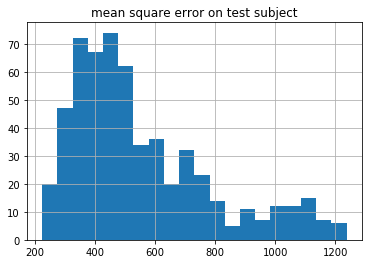

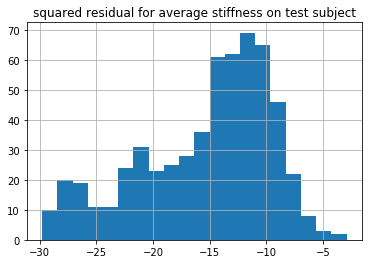

In [10]:
df.test_mse.hist(bins=20)
plt.title('mean square error on test subject')
plt.figure()
df.test_resid.hist(bins=20)
plt.title('residual for average stiffness on test subject')


In [53]:
df.query('loss=="robust" and model_cap==32 and mask_mixer=="intersection"')

batch_size  best_loss  coord_conv  dry_run  gamma    loss     lr    mask_mixer  mask_trimmer  model_cap  num_epochs  step_size subj  test_aug  test_ave_stiff  test_clip     test_mse  test_trans  train_aug  train_clip train_sample  train_trans  true_ave_stiff  val_aug  val_clip val_sample  val_trans  test_resid
2019-05-29_16-08-51_n428_subj_331        50.0  33.006466         0.0      0.0    0.3  robust  0.001  intersection           0.0       32.0       150.0       80.0  331       0.0       10.173408        1.0   727.040039         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  418.349789
2019-05-29_16-08-51_n180_subj_331        50.0  18.738111         1.0      0.0    0.3  robust  0.010  intersection           0.0       32.0       150.0       40.0  331       0.0       16.148970        1.0   525.782227         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  209.613607
2019-05-29_16-08-51_n176_subj_331        50.0  17.642509         1.0      0.0    0.3  robust  0.010  intersection           1.0       32.0       150.0       40.0  331       0.0       18.010897        1.0   431.073456         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  159.166276
2019-05-29_16-08-51_n328_subj_331        50.0  14.914753         0.0      0.0    0.3  robust  0.010  intersection           1.0       32.0       150.0       80.0  331       0.0       18.098558        1.0   445.944031         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  156.962060
2019-05-29_16-08-51_n88_subj_331         50.0  27.406153         0.0      0.0    0.3  robust  0.005  intersection           1.0       32.0       150.0       20.0  331       0.0       15.947165        1.0   510.815002         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  215.497789
2019-05-29_16-08-51_n184_subj_331        50.0  18.888988         0.0      0.0    0.3  robust  0.010  intersection           1.0       32.0       150.0       40.0  331       0.0       22.749445        1.0   318.713135         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0   62.056006
2019-05-29_16-08-51_n376_subj_331        50.0  19.570227         0.0      0.0    0.3  robust  0.005  intersection           1.0       32.0       150.0       80.0  331       0.0       18.758993        1.0   440.746124         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  140.849787
2019-05-29_16-08-51_n236_subj_331        50.0  22.971853         0.0      0.0    0.3  robust  0.005  intersection           0.0       32.0       150.0       40.0  331       0.0       19.904158        1.0   371.263458         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  114.979529
2019-05-29_16-08-51_n128_subj_331        50.0  52.041855         1.0      0.0    0.3  robust  0.001  intersection           1.0       32.0       150.0       20.0  331       0.0        4.446474        1.0  1030.980469         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  685.420380
2019-05-29_16-08-51_n80_subj_331         50.0  28.317453         1.0      0.0    0.3  robust  0.005  intersection           1.0       32.0       150.0       20.0  331       0.0       13.705433        1.0   631.263184         1.0        1.0         1.0      shuffle          1.0       30.627008      0.0       1.0    shuffle        1.0  286.339719
2019-05-29_16-08-51_n324_subj_331        50.0  15.572422         1.0      0.0    0.3  robust  0.010  intersection           0.0       32.0       150.0       80.0  331       0.0       12.554585        1.0   699.895020  